In [1]:
# NJ Transit Train Delay Prediction

#This project predicts arrival delays for NJ Transit trains using historical rail performance data (such as time, line, and route info) and machine learning regression models.

In [2]:
pip install pandas numpy scikit-learn matplotlib seaborn tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#data manipulation
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
df = pd.read_csv('nj_transit_data.csv')

In [5]:
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105,Secaucus Upper Lvl,38187,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187,Newark Penn Station,107,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107,Newark Airport,37953,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953,North Elizabeth,109,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [6]:
df.tail()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
256503,2018-03-31,0534,2.0,Bay Street,14,Glen Ridge,50,2018-03-31 19:02:00,2018-03-31 19:05:07,3.116667,departed,Montclair-Boonton,NJ Transit
256504,2018-03-31,0534,3.0,Glen Ridge,50,Bloomfield,19,2018-03-31 19:05:00,2018-03-31 19:08:06,3.100000,departed,Montclair-Boonton,NJ Transit
256505,2018-03-31,0534,4.0,Bloomfield,19,Watsessing Avenue,154,2018-03-31 19:07:00,2018-03-31 19:10:11,3.183333,departed,Montclair-Boonton,NJ Transit
256506,2018-03-31,0534,5.0,Watsessing Avenue,154,Newark Broad Street,106,2018-03-31 19:13:00,2018-03-31 19:21:02,8.033333,departed,Montclair-Boonton,NJ Transit
256507,2018-03-31,0534,6.0,Newark Broad Street,106,Hoboken,63,2018-03-31 19:38:00,2018-03-31 19:37:00,0.000000,estimated,Montclair-Boonton,NJ Transit


In [7]:
#keep only the columns that matter for prediction
relevant_cols = ['date', 'line', 'stop_sequence', 'from', 'to', 'scheduled_time', 'delay_minutes']
df = df[relevant_cols]

In [8]:
#drop rows with missing values in these key columns
df = df.dropna(subset=relevant_cols)

In [10]:
#check for missing data
df.isnull().sum()

date              0
line              0
stop_sequence     0
from              0
to                0
scheduled_time    0
delay_minutes     0
dtype: int64

In [11]:
#convert 'date' to datetime and extract time-based features
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


In [12]:
#drop rows where date conversion failed
df = df.dropna(subset=['hour', 'day_of_week', 'month', 'day'])

In [13]:
df['scheduled_time'] = pd.to_datetime(
    df['scheduled_time'],
    errors='coerce'
)

df['scheduled_hour'] = df['scheduled_time'].dt.hour
df['scheduled_minute'] = df['scheduled_time'].dt.minute

df = df.dropna(subset=['scheduled_hour', 'scheduled_minute'])

In [14]:
#convert station names and lines into unique numbers
le = LabelEncoder()
for col in ['line', 'from', 'to']:
    df[col] = le.fit_transform(df[col])

In [15]:
#drop columns that are now redundant or non-numeric
X = df.drop(columns=['date', 'scheduled_time', 'delay_minutes'])
y = df['delay_minutes']

In [16]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
#feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
#linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f'Linear Regression MAE: {mae_lr}')

Linear Regression MAE: 3.238073561826403


In [19]:
#random forest regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest MAE: {mae_rf}')

Random Forest MAE: 2.48905978764134


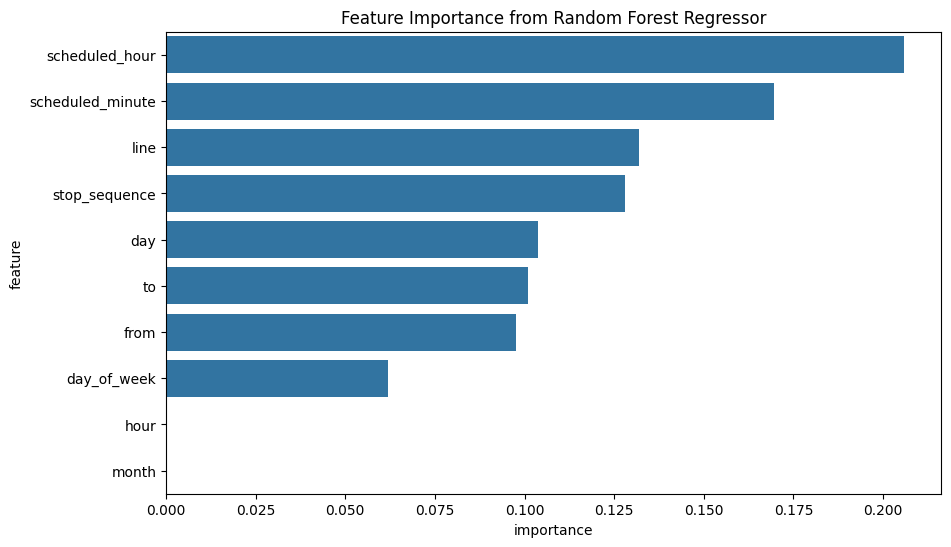

In [20]:
#feature importance (for random forest regressor)
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest Regressor')
plt.show()

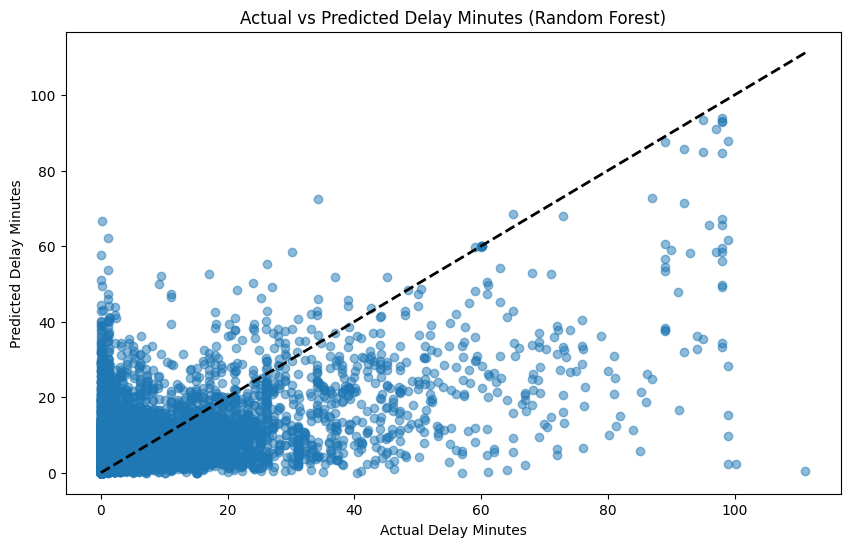

In [21]:
#actual vs predicted plot for random forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Actual Delay Minutes')
plt.ylabel('Predicted Delay Minutes')
plt.title('Actual vs Predicted Delay Minutes (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

In [23]:
import joblib
joblib.dump(rf_model, "njt_delay_model.pkl")

['njt_delay_model.pkl']